# Sample Program for Image Data by Using AIME
## Approximate Inverse Model Explanations (AIME)

Approximate Inverse Model Explanations (AIME) is an explainable AI method that derives global and local feature importance by approximating the inverse operator of a predictive model. Unlike perturbation- or sampling-based methods, AIME computes contributions analytically, which improves stability and reduces computational cost.

⸻

# Global Feature Importance

Let $X \in \mathbb{R}^{n \times p}$ be the training data with $n$ samples and $p$ features, and $Y \in \mathbb{R}^{n \times k}$ be the one-hot encoded label matrix with $k$ classes.

AIME derives an approximate inverse operator $A^\dagger$ such that

$$
W = A^\dagger Y,
$$

where $W \in \mathbb{R}^{k \times p}$ represents the global feature importance matrix.
Here, $W_{c,j}$ indicates the contribution of feature $j$ to class $c$.

To visualize global importance for each class $c$ in image data (e.g., CIFAR-10 with $32 \times 32 \times 3$ pixels):
1. Reshape $W_{c,:}$ into $(32,32,3)$.
2. Aggregate the three RGB channels into a 2D map using either:
  - $L_2$ norm:
    - $$
    M_{i,j} = \text{sign}(c^*) , \sqrt{R^2 + G^2 + B^2}
    $$
  - Max-Abs (recommended for sharper contrast):
    - $$
    M_{i,j} = \text{sign}(c^) , \max \big( |R|, |G|, |B| \big)
    $$
    - where $c^ = \arg\max_{{R,G,B}} | \cdot |$ is the dominant channel at pixel $(i,j)$.
3. Normalize $M$ to $[-1,1]$ and plot using a diverging colormap (blue → white → red).

⸻

## Local Feature Importance

- For a test input $x \in \mathbb{R}^p$, AIME derives local importance by weighting the global importance $W$ with the predicted or true class vector $y \in \mathbb{R}^k$:

- $$
\ell = (y^\top W) \odot x,
$$

- where $\odot$ denotes element-wise multiplication.
- Thus $\ell \in \mathbb{R}^p$ gives the per-feature contribution for $x$.

- Visualization steps:
  1.	Reshape $\ell$ into $(32,32,3)$.
  2.	Aggregate channels into a 2D map using $L_2$ or Max-Abs as in global importance.
  3.	Normalize to $[-1,1]$ and visualize with the same diverging colormap.
  4.	Display side-by-side with the original image for interpretability.

⸻

## Summary
- Global feature importance ($W$): shows how strongly each pixel contributes to distinguishing classes on average.
- Local feature importance ($\ell$): highlights which pixels mattered most for a specific image’s prediction.
- Aggregation strategies:
- $L_2$ norm → smooth, holistic representation of contributions.
- Max-Abs → sharp, emphasizes the dominant color channel per pixel.

- Both views are complementary: $L_2$ highlights distributed contributions, while Max-Abs highlights strong localized effects.



In [1]:
!pip -q install aime-xai

In [32]:
# --- Visualization Utility ---
def to_img(arr_1d):
    """(3072,) → (32,32,3)"""
    return arr_1d.reshape(32,32,3)

def minmax01(a):
    a = a.astype(np.float32)
    mn, mx = a.min(), a.max()
    if mx - mn < 1e-12:
        return np.zeros_like(a)
    return (a - mn) / (mx - mn)

import matplotlib.colors as mcolors
import numpy as np

def compute_signed_2d(img3, mode="l2", clip_pct=99.5):
"""
    img3: Contribution map (32,32,3) (local or global is OK)
    mode: "l2" | "maxabs"
        - "l2"    : sign = dominant channel, size = L2 norm
        - "maxabs": sign = dominant channel, magnitude = max(|R|,|G|,|B|)
    clip_pct: percentile of clip upper limit (to prevent colors from being crushed by outliers)
    return: 2D map normalized to [-1,1]
    """
    C = img3  # (H,W,3)
    absC = np.abs(C)
    # 優勢チャネルのインデックス (H,W)
    dom_idx = np.argmax(absC, axis=2)

    if mode == "l2":
        mag = np.sqrt((C**2).sum(axis=2))       # (H,W)
    elif mode == "maxabs":
        mag = absC.max(axis=2)                  # (H,W)
    else:
        raise ValueError("mode must be 'l2' or 'maxabs'")

    # 符号 = 優勢チャネルの符号
    sign = np.take_along_axis(np.sign(C), dom_idx[...,None], axis=2).squeeze(2)
    signed = sign * mag

    # ロバスト正規化（外れ値対策）
    vmax = np.percentile(np.abs(signed), clip_pct) + 1e-12
    signed = np.clip(signed, -vmax, vmax) / vmax  # [-1,1]
    return signed


def show_global_signed(w_c3, title, fname, mode="maxabs"):
"""
    w_c3: (32,32,3) Global contribution (W[c] of that class formatted as 32x32x3)
    mode: "maxabs" Recommended (sign of dominant channel × max(|R|,|G|,|B|))
    """
    signed2d = compute_signed_2d(w_c3, mode=mode)  # [-1,1]
    plt.figure(figsize=(4,4))
    plt.imshow(signed2d, cmap="bwr",
               norm=mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1))
    plt.title(title)
    plt.axis('off')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.savefig(fname, dpi=200, bbox_inches='tight')
    plt.show()
    plt.close()

def show_local_with_original(orig_img3, contrib_img3, true_name, fname, mode="maxabs"):
    signed2d = compute_signed_2d(contrib_img3, mode=mode)
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(orig_img3)
    axes[0].set_title(f"Original (true={true_name})")
    axes[0].axis('off')
    im = axes[1].imshow(signed2d, cmap="bwr",
                        norm=mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1))
    axes[1].set_title(f"Local Importance ({mode}, signed)")
    axes[1].axis('off')
    fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.savefig(fname, dpi=200, bbox_inches='tight')
    plt.show()
    plt.close()

In [4]:
# =========================
# Colab-ready AIME × CIFAR-10 demo
# Global & Local Feature Importance Heatmaps
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

from tensorflow.keras.datasets import cifar10
from aime_xai import AIME

# --- 0) CIFAR-10 load ---
# Image: (N,32,32,3), Label: (N,)
(X_all, y_all), (X_all_test, y_all_test) = cifar10.load_data()
y_all = y_all.ravel()
y_all_test = y_all_test.ravel()

#Combine and split learning/testing (optional: split again without using Keras' train/test)
X = np.concatenate([X_all, X_all_test], axis=0)
y = np.concatenate([y_all, y_all_test], axis=0)

# 0-1 Normalization & Flattening (N, 3072)
X = (X.astype(np.float32) / 255.0).reshape(len(X), -1)

# Class name (CIFAR-10)
class_names = np.array([
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
])

# --- 1) Learning/Test Division ---
X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

# --- 2) Convert y to one-hot ---
enc = OneHotEncoder(sparse_output=False, categories='auto')
y_train = enc.fit_transform(y_train_raw.reshape(-1,1))
y_test_onehot = enc.transform(y_test_raw.reshape(-1,1))

# --- 3) Simple classifier (e.g., logistic regression) ---
# Since it takes time due to high dimensions and many samples, it is possible to thin out the data a little.
# Example: If speed is important, remove the comments below and perform subsampling.
# idx_sub = np.random.RandomState(0).choice(len(X_train), size=20000, replace=False)
# X_train, y_train, y_train_raw = X_train[idx_sub], y_train[idx_sub], y_train_raw[idx_sub]

scaler = StandardScaler(with_mean=True, with_std=True)
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

# We do not need Macine learning model to appply AIME.
# AIME can derive explanations using only data.
#clf = LogisticRegression(
#    multi_class='multinomial',
#    solver='saga',
#    max_iter=100,
#    n_jobs=-1,
#    verbose=0
#)
#clf.fit(X_train_sc, y_train_raw)



In [5]:
# --- 4) Building the AIME Explainer ---
# Pass X_train(2D) and y_train(one-hot) to AIME.
explainer = AIME()
explainer.create_explainer(X_train_sc, y_train, normalize=True)

Global importance matrix shape (classes × features): (10, 3072)


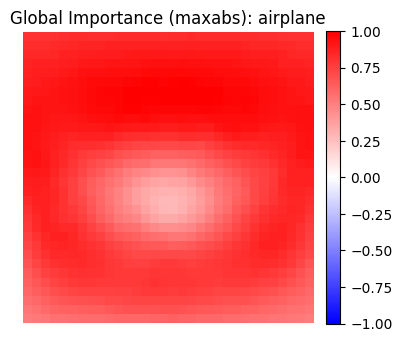

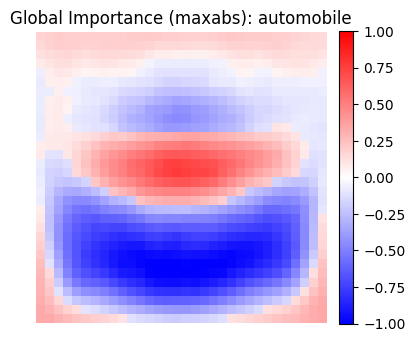

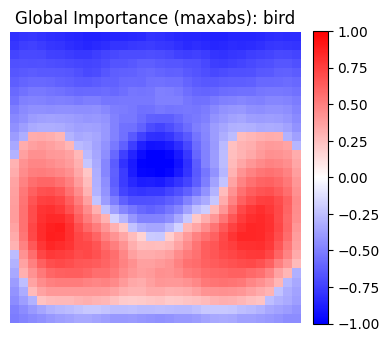

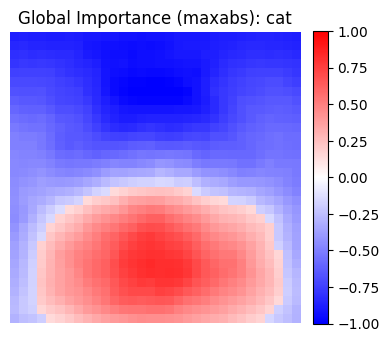

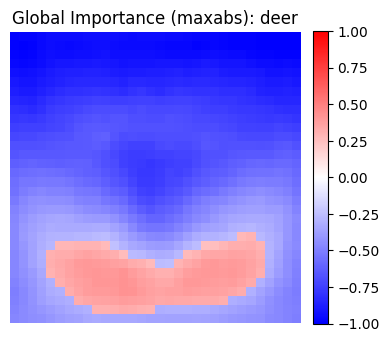

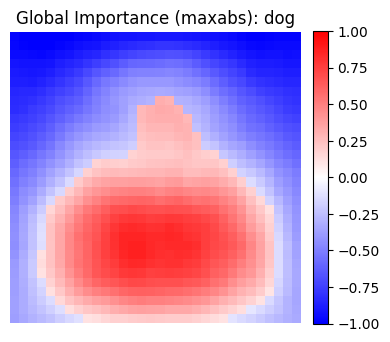

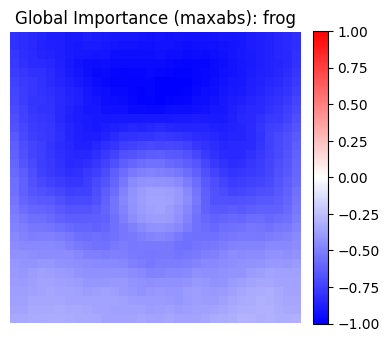

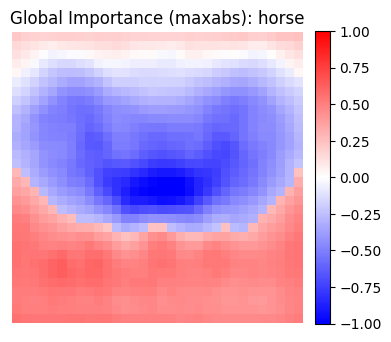

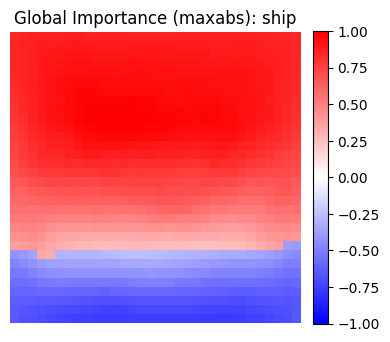

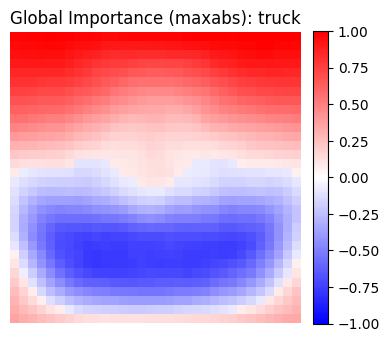

Saved & displayed per-class global importance heatmaps as global_*_signed_maxabs.png


In [33]:
# Class name (match the order of OneHot)
# enc.categories_[0] is the sequence 0..9. Pass class_names in the same order.
class_names_for_aime = class_names[enc.categories_[0].astype(int)]

global_importance_df = explainer.global_feature_importance_without_viz(
    class_names=class_names_for_aime
)
# Expected shape: (n_classes, n_features)
W = global_importance_df.to_numpy()  # W[c, j]

print("Global importance matrix shape (classes × features):", W.shape)

# --- 6) Global Feature Importance - Heatmap by class ---
# Weight vector W[c] (3072) for class c is converted to (32,32,3) and normalized to 0-1 using min-max, then visualized.
# --- Global Feature Importance Heat Map (by class) ---
for c, cname in enumerate(class_names_for_aime):
    w_c3 = W[c].reshape(32, 32, 3)
    show_global_signed(w_c3, f"Global Importance (maxabs): {cname}",
                       f"global_{cname}_signed_maxabs.png", mode="maxabs")

print("Saved & displayed per-class global importance heatmaps as global_*_signed_maxabs.png")

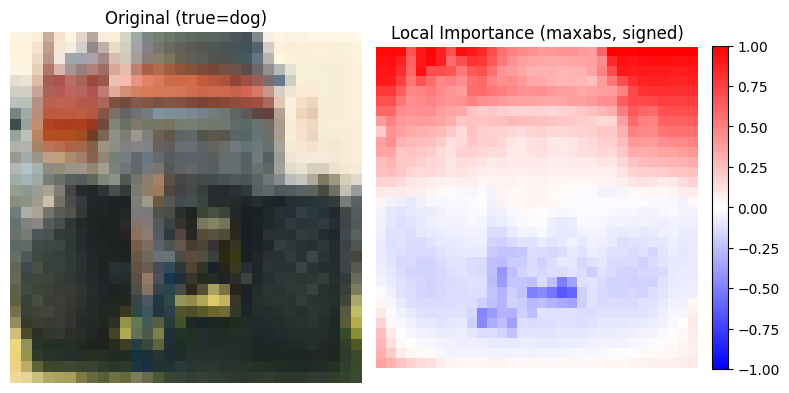

In [40]:
# ===== (Replacement) 7) Local Feature Importance =====
# Example: First sample of test
idx=3
x_row_orig = X_test[idx]         # (3072,) - Original scale (0-1)
x_row_sc   = X_test_sc[idx]      # (3072,) - After scaling

# one-hot vector (shape (10,))
y_vec = y_test_onehot[idx].astype(np.float32)
truename=class_names[y_test_raw[idx]]

# Local importance: (y_vec @ W) * x_row
local_importance = (y_vec @ W) * x_row_orig   # (3072,)

# Normalization (maintaining relative relationships between symbols)
den = np.max(np.abs(local_importance)) + 1e-12
local_norm = local_importance / den

# --- Local Feature Importance Heat Map ---
local_img3 = local_importance.reshape(32,32,3)
orig_img3  = to_img(x_row_orig)
show_local_with_original(orig_img3, local_img3, true_name, "local_pair_maxabs.png", mode="maxabs")